In [1]:
import gym
import time
import matplotlib.pyplot as plt
from pyswip import Prolog
from utils import create_level, define_reward, process_state, perform_action, show_match

In [2]:
H = 15
W = 15
NUM_EPISODES = 10
MAX_STEPS = 200
MONSTER = ['goblin', 'kobold', 'sewer rat', 'homunculus']
# MONSTER = []
WEAPON = ["bow", "tsurugi"]
# WEAPON = []
PATH = 'kb.pl'

In [3]:
des_file = create_level(width = W, height = H, monsters = MONSTER, weapons = WEAPON, potion = True, armor = True)
print(des_file)
reward_manager = define_reward(monsters = MONSTER)


MAZE: "mylevel", ' '
FLAGS:hardfloor
INIT_MAP: solidfill,' '
GEOMETRY:center,center
MAP
...............
...............
...............
...............
...............
...............
...............
...............
...............
...............
...............
...............
...............
...............
...............
ENDMAP
REGION:(0,0,15,15),lit,"ordinary"
WALLIFY
MONSTER:"goblin",random
MONSTER:"kobold",random
MONSTER:"sewer rat",random
MONSTER:"homunculus",random
OBJECT:(')',"bow"),random
OBJECT:(')',"tsurugi"),random
OBJECT:('!',"full healing"),random
OBJECT:('[',"leather armor"),random



In [4]:
env = gym.make('MiniHack-Skill-Custom-v0',
               character="sam-hum-neu-mal",
               observation_keys=('screen_descriptions','inv_strs','blstats','message','pixel'),
               des_file=des_file,
               reward_manager=reward_manager
               )

In [5]:
obs = env.reset()
env.render()


Konnichi wa Agent, welcome to NetHack!  You are a lawful male human Samurai.    
                                                                                
                                                                                
                               -----------------                                
                               |....i..........|                                
                               |...............|                                
                               |...............|                                
                               |@............o.|                                
                               |...............|                                
                               |...............|                                
                               |...............|                                
                               |.......).......|                                
                           

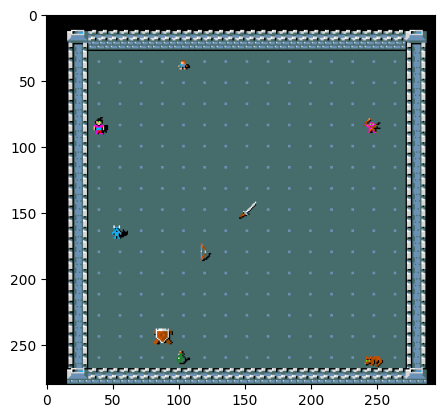

In [6]:
plt.imshow(obs['pixel'][20:300, 480:775])

Initialize the knowledge base.

In [7]:
KB = Prolog()
KB.consult(PATH)

#### Main code
- Perform `NUM_EPISODES` experiences in the environment.
- Use `Prolog` to define the axioms and choose the action to perform.
- The main goal is to _reach and eat_ the `apple`.

In [8]:

for i in range(0):
    print(f'Action performed: {i} {repr(env.actions[i])}')

Episode 10 - 23 steps
End status: TASK_SUCCESSFUL
Final reward: 3.9600000000000004
After 10 episodes, mean return is 3.0490000000000004
and the total number of winning episodes is 8
The rewards of the episodes are: [1.92, 3.95, 1.94, 2.95, 2.9000000000000012, 3.9699999999999998, 0.99, 3.96, 3.95, 3.9600000000000004]


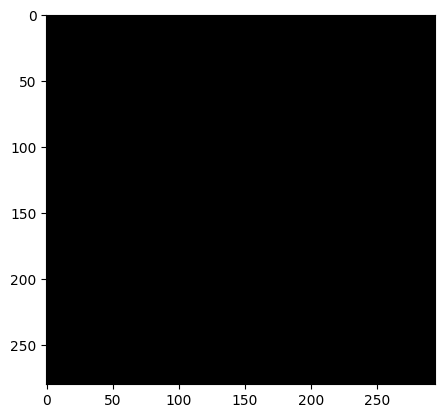

In [9]:
rewards = [] 
wins = 0
for episode in range(NUM_EPISODES):
    # count the number of steps of the current episode
    steps = 0
    # store the cumulative reward
    reward = 0.0
    # collect obs['pixel'] to visualize
    ep_states = []

    obs = env.reset()
    ep_states.append(obs['pixel'])
    done = False

    # Main loop
    while not done and steps < MAX_STEPS:
        # Get the observation from the env and assert the facts in the kb
        process_state(obs, KB, MONSTER)
        # Query Prolog
        # Run the inference and get the action to perform
        # Get the first answer from Prolog -> the top-priority action
        try:
            action = list(KB.query('action(X)'))[0]
            action = action['X']
            # print("ACTION: ", action)
        except Exception as e:
            print(e)
            action = None

        # Perform the action in the environment
        if action:
            ret = perform_action(action, env, KB)
            if ret != None:
                obs, rwd, done, info = ret
                reward += rwd
                ep_states.append(obs['pixel'])
                # env.render()
        else:
            print("ERROR: No action can be performed")
            break

        steps += 1
    
    if done:
        wins += 1

    # Display game with interface
    show_match(ep_states)
    # Print information about the ended episode
    print(f'Episode {episode + 1} - {steps} steps')
    print(f'End status: {info["end_status"].name}')
    print(f'Final reward: {reward}')

    rewards.append(reward)

    # reset the environment and retract axioms that may cause errors
    obs = env.reset()
    KB.retractall('stepping_on(agent,_)')


print(f'After {NUM_EPISODES} episodes, mean return is {sum(rewards)/NUM_EPISODES}')
print(f'and the total number of winning episodes is {wins}')
print("The rewards of the episodes are:", rewards)